In this notebook we will go through 4 fundamental machine learning algos.
1. linear regression
2. classification
3. clustering
4. hidden markov models

In [1]:
!pip install -q sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
!pip install matplotlib-venn

In [3]:
!pip install tensorflow-probability

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf


In [5]:
# loading dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dftest = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')   #testing dataset
print(type(dftrain['survived'].iloc[9]))
y_train = dftrain.pop('survived')  # pop method for exatracting column
y_test = dftest.pop('survived')




<class 'numpy.int64'>


In [6]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


<Axes: >

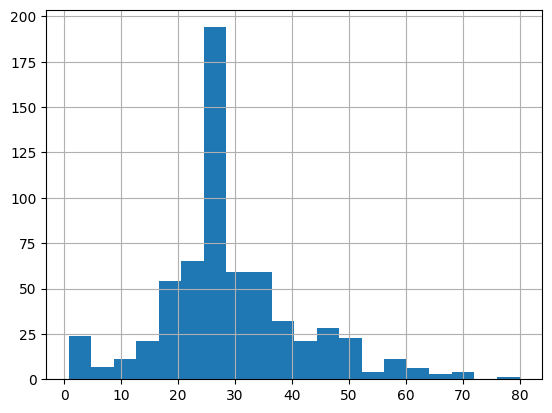

In [ ]:
dftrain.age.hist(bins=20)

<Axes: >

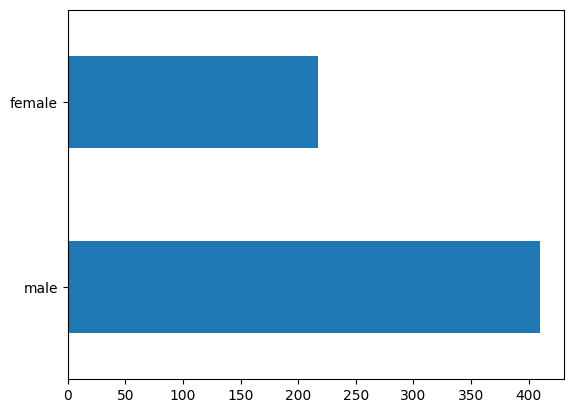

In [ ]:
dftrain.sex.value_counts().plot(kind='barh')

<Axes: >

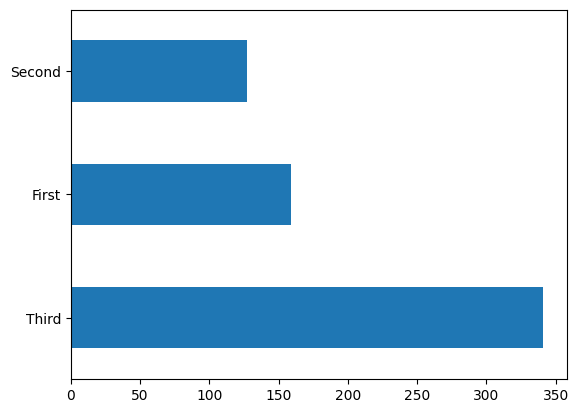

In [ ]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survival')

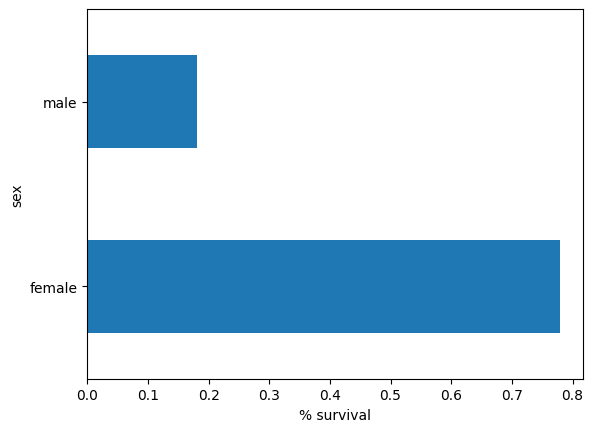

In [ ]:
# this computes the survives percentage of the passengers according to there gender
# it group by them according to the sex using groupby('sex') method then calculates the respected mean
pd.concat([dftrain, y_train], axis = 1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survival')

after analysing the dataset info we got


1.majority passengers are in their 20's or 30's



2.majority passengers are male


3.majority passengers arein third class


4.females have much higher chance of survival

In [7]:
categorical_column = ['sex', 'n_siblings_spouses', 'parch','class','deck','embark_town','alone']

numeric_column = ['age','fare']

feature_columns = []


# Numerical values preparation

for feature_name in categorical_column:
  vocabulary = dftrain[feature_name].unique() # extract all the unique values from given feature column

  # categorical_column_with_vocabulary_list creates the feature_column
  # consists of the mapped categorical values to numeric values
  # it takes two arguments feature_name and vocabulary
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in numeric_column:
  # numeric_column create the feature column
  # arguments taken by the method feature name and datatype
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype= tf.float32))

print(feature_columns)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

Training Process:
1.  Split dataset in the small batches.
2.  Don't feed entire data to model at once rather feed it multiple times in small batches according to the no of epochs.
3.  Epoch is simply one stream of entire dataset. no of epochs defines the amount of times model will see the entire data.
4. here we need input function to define how dataset converts to small batches at each epoch.





Input Function:

*   TensorFlow model requires the given data in tensorflow.data.Dataset OBJECT.
*   to convert the pandas dataframe to tensorflow.data.Dataset object we need INPUT FUNCTION.



In [10]:
# INPUT FUNCTION
# det make_input_fn makes the input func and returns the func object to where it has been called
def make_input_fn(data_df, label_df, num_epoch=20, shuffle = True, batch_size = 32):
  def input_function():

    # use tensorflow.data.Dataset.from_tensor_slices to create the object
    # arguments taken dictionary representation of data and corresponding label
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df),label_df))

    if shuffle:
      ds = ds.shuffle(1000) # randomise the order of data


    # ds.batch(batch_size) divides ds in smaller manageable batches of size batch_size
    # .repeat(num_epoch) this causes the dataset to be iterated over multiple times during training
    ds = ds.batch(batch_size).repeat(num_epoch)
    print(ds)
    return ds
  return input_function

# here we'll call input_function that returned to us to get a dataset object
train_input_fn = make_input_fn(dftrain, y_train)
test_input_fn = make_input_fn(dftest, y_test, num_epoch=1, shuffle=False)

#create linear classifier using estimator module of tensorflow
# by passing the feature columns we created earlier
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

# Training the model
linear_est.train(train_input_fn)

# get model metrics by testing
result = linear_est.evaluate(test_input_fn)

clear_output()

print(result['accuracy'])


0.7689394


In [11]:
print(train_input_fn)

<function make_input_fn.<locals>.input_function at 0x7a0af2c4df30>


In [ ]:
# actual prediction using model

result = list(linear_est.predict(test_input_fn))
print(result)

print(result[5]['probabilities'][1])

print(dftest.loc[5])
print(y_test.loc[5])


Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


[{'logits': array([-2.282836], dtype=float32), 'logistic': array([0.09255449], dtype=float32), 'probabilities': array([0.90744555, 0.09255449], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([-0.01116013], dtype=float32), 'logistic': array([0.49721003], dtype=float32), 'probabilities': array([0.50279   , 0.49720997], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([1.449006], dtype=float32), 'logistic': array([0.8098454], dtype=float32), 'probabilities': array([0.1901546, 0.8098454], dtype=float32), 'class_ids': array([1]), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([0.971186], dtype=float3